# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

C:\Users\fill\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import numpy as np
import pandas as pd

C:\Users\fill\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="batch_folder", 
                                       batch_size=100)
batch_vectorizer = artm.BatchVectorizer(data_path="batch_folder", data_format='batches')

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1})

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
dictionary = artm.Dictionary(name='dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.seed=1
model_artm.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [9]:
# Ваш код
model_artm.cache_theta = True
SSRb = artm.SmoothSparsePhiRegularizer(name='SparsePhi_bcg', tau=1e5, topic_names = "bcg", 
                                       dictionary=dictionary, class_ids = "text")
SSRb.dictionary_name = "dictionary"
model_artm.regularizers.add(SSRb)

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [10]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary='dictionary'))

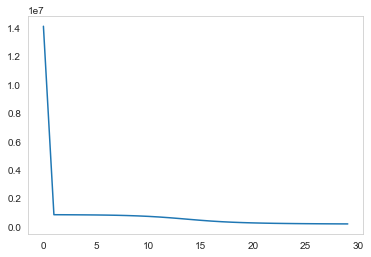

In [11]:
# Ваш код
model_artm.num_document_passes = 1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [ ]:
#topic_names[:-1]

In [12]:
# Ваш код
SSRs = artm.SmoothSparsePhiRegularizer(name='SparsePhi_sbj', tau=-1e5, topic_names = topic_names[:-1], 
                                       dictionary=dictionary, class_ids = "text")
SSRs.dictionary_name = "dictionary"
model_artm.regularizers.add(SSRs)

C:\Users\fill\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Выполните еще 15 проходов по коллекции.

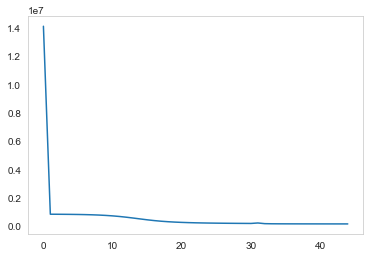

In [13]:
# Ваш код
#model_artm.regularizers['SparsePhi_sbj'].tau = -1e5
model_artm.num_document_passes = 1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

##### Интерпретация тем

In [ ]:
#model_artm.get_phi()

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [135]:
# Ваш код
#print(model_artm.score_tracker["top_authors"].last_tokens)
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=' ')
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:
        print(word, end=' ')
    print();
    
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=' ')
    for word in model_artm.score_tracker["top_authors"].last_tokens[topic_name]:
        print(word, end=' ')
    print();    

sbj0:  теория частица модель взаимодействие три состоять физика сила кварк сильный стандартный симметрия элементарный фундаментальный нейтрино 
sbj1:  при получать структура материал использовать создавать свойство высокий метод различный температура элемент технология связь возможность 
sbj2:  рассказывать жизнь сам некий концепция граница над американский занимать замечательный полный должно михаил положение ключевой 
sbj3:  понимать что-то далее память общий образование университет казаться предмет школа опыт соответственно признак восприятие воспринимать 
sbj4:  задача решать получаться речь лицо смотреть посмотреть читать третий мышление категория понятно позиция значит предложение 
sbj5:  весь время друг нет вид потом находить жить действительно представление тело никакой внутренний среди наоборот 
sbj6:  говорить конечно город место вот эпоха культурный собственно городской никто многое естественно попадать документ герой 
sbj7:  человек ситуация хотя степень вариант цель конкре

sbj17:  Александр_Беленький Александр_Сафонов Илья_Шкредов Дмитрий_Ветров Сергей_Гуриев Станислав_Протасов Руслан_Смелянский Мануэль_Маццара Сезар_Идальго Михаил_Киселев Григорий_Кабатянский Даниэль_Сельва Арчил_Балахванцев Джу_Йонг_Ли Евгений_Хоров 
sbj18:  Алексей_Муравьёв Владимир_Плунгян Андрей_Кибрик Кирилл_Бабаев Александр_Пиперски Георгий_Старостин Марк_Ульянов Анна_Дыбо Дмитрий_Худяков Алексей_Лебедев Владимир_Беликов Петр_Аркадьев Нина_Сумбатова Сергей_Арутюнов Борис_Иомдин 
sbj19:  Евгений_Шеваль Константин_Северинов Максим_Франк-Каменецкий Сергей_Киселев Антон_Буздин Михаил_Гельфанд Петр_Федичев Александр_Апт Евгений_Куликов Андрей_Летаров Александр_Габибов Константин_Мирошников Сергей_Науменко Роман_Ефремов Алексей_Кондрашов 
sbj20:  Владимир_Белотелов Алексей_Рубцов Алексей_Акимов Владимир_Мележик Андрей_Савельев-Трофимов Сергей_Демокритов Юджин_Ползик Владимир_Шалаев Алексей_Желтиков Пётр_Турчин Иван_Сорокин Виталий_Пальчиков Кит_Моффат Владимир_Польшаков Виктор_Задков 
s

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [21]:
sbj_topic_labels = ['теория частиц', 'структура материалов', 'жизнеописание', 'память', 'мышление', 'время', 
                   'город', 'социум', 'правоведение', 'медицина', 'биология', 'система', 
                    'история', 'социология', 'астрономия', 'экономика', 'вопрос', 'IT', 'лингвистика', 
                    'биоинформатика', 'теория поля', 'культурология', 'новая история', 'советский', 
                    'философия науки', 'частность движения', 'часть', 'наука', 'рисование']   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

C:\Users\fill\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [18]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model_artm.get_phi(class_ids='author')
print(phi_a)
theta = model_artm.get_theta()
print(theta)

                            sbj0          sbj1          sbj2          sbj3  \
Ярослав_Исполатов       0.000000  0.000000e+00  4.529278e-13  1.062612e-15   
Сергей_Демокритов       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
Руслан_Смелянский       0.000000  0.000000e+00  2.545220e-14  0.000000e+00   
Александр_Апт           0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
Людмила_Новикова        0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
...                          ...           ...           ...           ...   
Дарья_Радченко          0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
Ирина_Каспэ             0.000000  0.000000e+00  0.000000e+00  4.139919e-15   
Марина_Корсакова-Крейн  0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
Павел_Степанцов         0.000000  0.000000e+00  2.911481e-09  0.000000e+00   
Дэвид_Гросс             0.016081  1.020492e-16  0.000000e+00  5.598334e-16   

                                sbj4          sbj5          sbj

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

C:\Users\fill\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


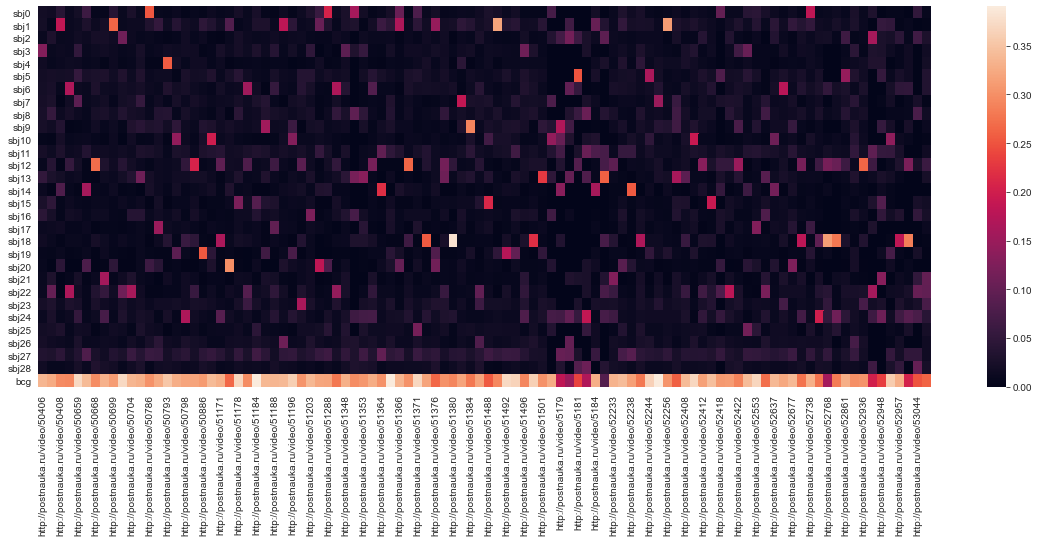

In [19]:
# Ваш код
#print(theta.iloc[:,0:100])
plt.figure(figsize=(20, 7));
seaborn.heatmap(theta.iloc[:,0:100]);

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [33]:
# Ваш код
t = theta.to_numpy()
pt = t.sum(axis=1)/t.sum()
df=pd.DataFrame([pt], columns = topic_labels)
ind = np.argsort([pt])[0][-1:1:-1]
print(list(ind))
for ii in ind[1:7]:
    print(topic_labels[ii])
    
ind = np.argsort([pt])[0]
print(list(ind))
for ii in ind[0:3]:
    print(topic_labels[ii])    
df


[29, 1, 24, 12, 27, 19, 18, 13, 11, 28, 22, 14, 9, 10, 8, 20, 0, 2, 23, 5, 21, 6, 26, 7, 3, 15, 25, 16]
структура материалов
философия науки
история
наука
биоинформатика
лингвистика
[4, 17, 16, 25, 15, 3, 7, 26, 6, 21, 5, 23, 2, 0, 20, 8, 10, 9, 14, 22, 28, 11, 13, 18, 19, 27, 12, 24, 1, 29]
мышление
IT
вопрос


C:\Users\fill\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,теория частиц,структура материалов,жизнеописание,память,мышление,время,город,социум,правоведение,медицина,...,теория поля,культурология,новая история,советский,философия науки,частность движения,часть,наука,рисование,Фоновая тема
0,0.022816,0.041587,0.022349,0.016516,0.011543,0.020676,0.017936,0.017482,0.024922,0.026528,...,0.024238,0.018501,0.029389,0.02112,0.039443,0.014307,0.017524,0.038047,0.030832,0.275328


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

<AxesSubplot:>

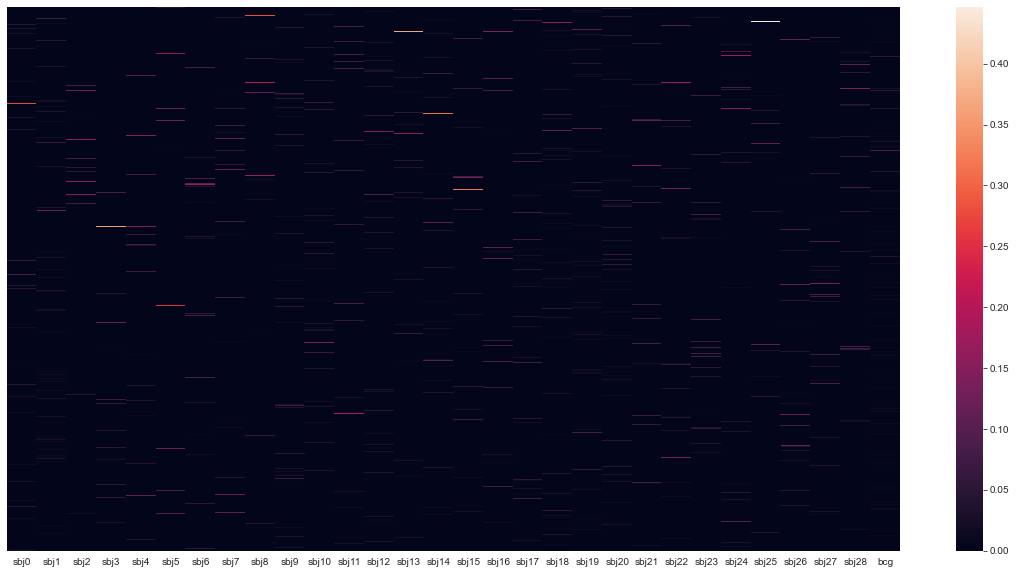

In [26]:
# Ваш код
plt.figure(figsize=(20, 10));
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [32]:
num_t = np.sum(phi_a>0.01, axis = 1)
print(num_t[num_t>=3])

Александр_Павлов          3
Михаил_Соколов            3
Гасан_Гусейнов            4
Алексей_Козырев           3
Станислав_Дробышевский    3
Михаил_Алексеевский       3
Михаил_Киселев            3
Ян_Левченко               3
dtype: int64


C:\Users\fill\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [45]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [68]:
# Ваш код
   
#print(np.shape(phi_a))
pta = np.zeros(np.shape(phi_a))
#print(np.shape(pta))
                
for t in range(len(pt)):
    for a in range(np.shape(phi_a)[0]):
        pta[a,t] = phi_a.to_numpy()[a,t]*pt[t]/(phi_a.to_numpy()[a,:]*pt).sum();



<AxesSubplot:>

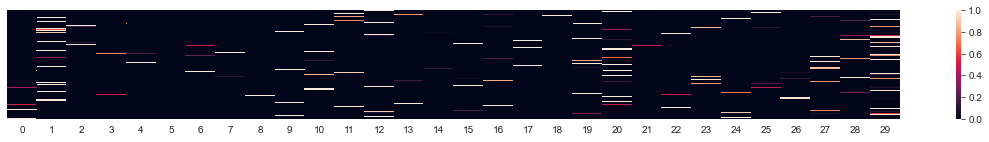

In [69]:
# Ваш код
plt.figure(figsize=(20, 2));
seaborn.heatmap(pta, yticklabels=False)

In [70]:
embedding = MDS(random_state=1, dissimilarity='precomputed')
distances = pairwise_distances(pta, metric='cosine')
pta2 = embedding.fit_transform(distances)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

C:\Users\fill\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


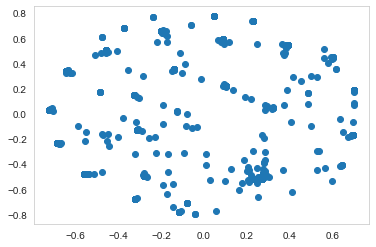

In [71]:
# Ваш код
plt.scatter(pta2[:,0], pta2[:,1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

C:\Users\fill\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


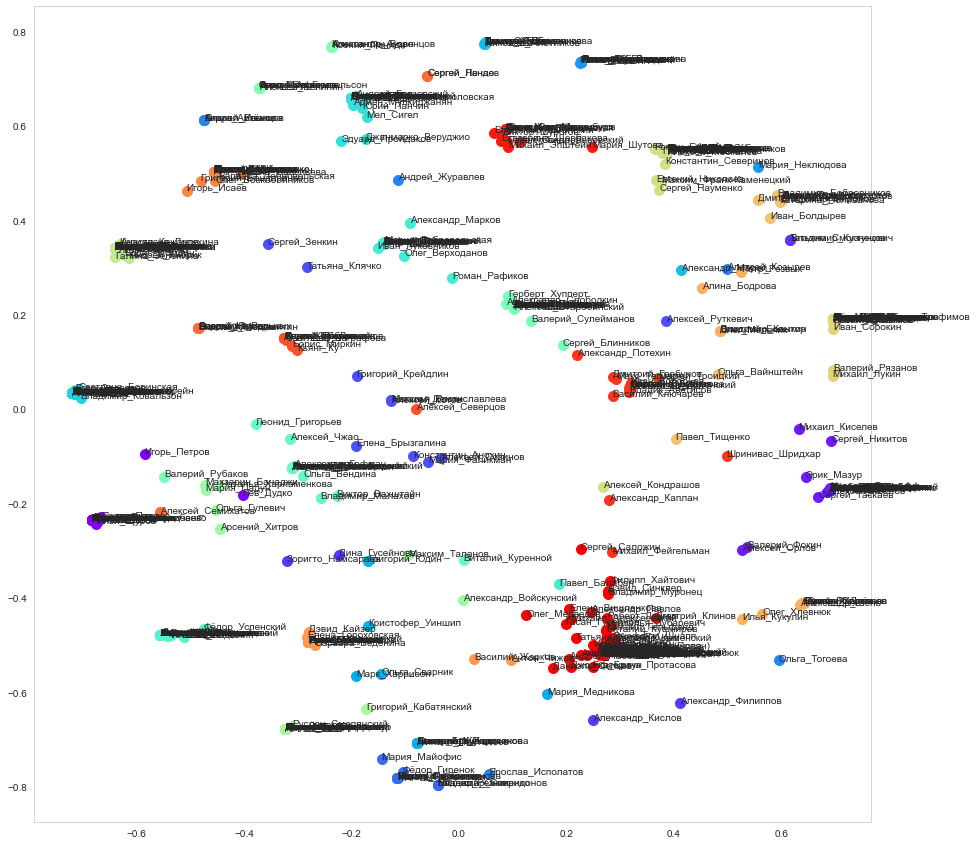

In [157]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
cpta = np.argmax(pta, axis=1)
#print(phi_a.index[0])
plt.figure(figsize=(15, 15));
for ii in range(len(cpta)):
    plt.scatter(pta2[ii,0], pta2[ii,1], color = colors[cpta[ii]],s=100)
for jj in range(np.shape(pta2)[0]):
    plt.annotate(text = phi_a.index[jj], xy = (pta2[jj,0], pta2[jj,1]))
    
plt.savefig('authors_map.pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [84]:
# Ваш код
pdt = np.zeros(np.shape(theta))
#print(np.shape(pta))
                
for t in range(np.shape(theta)[1]):
    for d in range(np.shape(theta)[0]):
        pdt[d,t] = theta.to_numpy()[d,t]/(theta.to_numpy()[:,t]).sum();


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [85]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [86]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [158]:
# Ваш код
import sys
#print()
display(HTML(u"<h1>Навигатор</h1>"))
for t in range(len(topic_labels)-1):
    display(HTML("<h3>" + topic_labels[t] +"</h3>"))
    for word in model_artm.score_tracker["top_words"].last_tokens[model_artm.topic_names[t]]:
        print(word, end=' ')
    print();
    for ii in np.argsort(pdt[t,:])[-1:-11:-1]:
        print(theta.columns[ii])
    

C:\Users\fill\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


теория частица модель взаимодействие три состоять физика сила кварк сильный стандартный симметрия элементарный фундаментальный нейтрино 
http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/47952
http://postnauka.ru/video/18873
http://postnauka.ru/video/47826
http://postnauka.ru/video/2945
http://postnauka.ru/video/1922
http://postnauka.ru/video/47947
http://postnauka.ru/video/47950
http://postnauka.ru/video/1894


при получать структура материал использовать создавать свойство высокий метод различный температура элемент технология связь возможность 
http://postnauka.ru/video/9144
http://postnauka.ru/video/57995
http://postnauka.ru/video/13700
http://postnauka.ru/video/13544
http://postnauka.ru/video/31182
http://postnauka.ru/video/18048
http://postnauka.ru/video/48107
http://postnauka.ru/video/10379
http://postnauka.ru/video/50340
http://postnauka.ru/video/30655


рассказывать жизнь сам некий концепция граница над американский занимать замечательный полный должно михаил положение ключевой 
http://postnauka.ru/video/5517
http://postnauka.ru/video/12083
http://postnauka.ru/video/42088
http://postnauka.ru/video/53228
http://postnauka.ru/video/50097
http://postnauka.ru/video/13538
http://postnauka.ru/video/21318
http://postnauka.ru/video/3604
http://postnauka.ru/video/13098
http://postnauka.ru/video/17923


понимать что-то далее память общий образование университет казаться предмет школа опыт соответственно признак восприятие воспринимать 
http://postnauka.ru/video/50347
http://postnauka.ru/video/2973
http://postnauka.ru/video/57648
http://postnauka.ru/video/54916
http://postnauka.ru/video/3603
http://postnauka.ru/video/55217
http://postnauka.ru/video/31198
http://postnauka.ru/video/34950
http://postnauka.ru/video/55533
http://postnauka.ru/video/56050


задача решать получаться речь лицо смотреть посмотреть читать третий мышление категория понятно позиция значит предложение 
http://postnauka.ru/video/55068
http://postnauka.ru/video/50793
http://postnauka.ru/video/47548
http://postnauka.ru/video/26633
http://postnauka.ru/video/25101
http://postnauka.ru/video/26207
http://postnauka.ru/video/24451
http://postnauka.ru/video/56042
http://postnauka.ru/video/54744
http://postnauka.ru/video/53945


весь время друг нет вид потом находить жить действительно представление тело никакой внутренний среди наоборот 
http://postnauka.ru/video/27831
http://postnauka.ru/video/5181
http://postnauka.ru/video/3509
http://postnauka.ru/video/31990
http://postnauka.ru/video/21637
http://postnauka.ru/video/44271
http://postnauka.ru/video/23111
http://postnauka.ru/video/36976
http://postnauka.ru/video/52244
http://postnauka.ru/video/38508


говорить конечно город место вот эпоха культурный собственно городской никто многое естественно попадать документ герой 
http://postnauka.ru/video/13156
http://postnauka.ru/video/24279
http://postnauka.ru/video/23470
http://postnauka.ru/video/48112
http://postnauka.ru/video/38510
http://postnauka.ru/video/40004
http://postnauka.ru/video/48478
http://postnauka.ru/video/57318
http://postnauka.ru/video/13744
http://postnauka.ru/video/9150


человек ситуация хотя степень вариант цель конкретный ответ действовать настоящий целое деятельность трудность организация америка 
http://postnauka.ru/video/15341
http://postnauka.ru/video/56618
http://postnauka.ru/video/7767
http://postnauka.ru/video/47457
http://postnauka.ru/video/22722
http://postnauka.ru/video/51382
http://postnauka.ru/video/46431
http://postnauka.ru/video/48994
http://postnauka.ru/video/52246
http://postnauka.ru/video/5999


право кто здесь давать случай отношение вещь правило действие закон перед интерес римский считаться нельзя 
http://postnauka.ru/video/16822
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/42221
http://postnauka.ru/video/49455
http://postnauka.ru/video/31688
http://postnauka.ru/video/31666
http://postnauka.ru/video/42220
http://postnauka.ru/video/39998
http://postnauka.ru/video/41100


проблема связывать уровень либо состояние данный механизм заболевание поведение развиваться день пациент фактор помогать лечение 
http://postnauka.ru/video/11361
http://postnauka.ru/video/13746
http://postnauka.ru/video/532
http://postnauka.ru/video/30606
http://postnauka.ru/video/45961
http://postnauka.ru/video/7753
http://postnauka.ru/video/49206
http://postnauka.ru/video/51384
http://postnauka.ru/video/38003
http://postnauka.ru/video/8661


область мозг условие изменение животное эволюция вода робот влиять нейрон выделять похожий назад сигнал оценка 
http://postnauka.ru/video/30673
http://postnauka.ru/video/9861
http://postnauka.ru/video/12971
http://postnauka.ru/video/19071
http://postnauka.ru/video/49437
http://postnauka.ru/video/8953
http://postnauka.ru/video/34424
http://postnauka.ru/video/26232
http://postnauka.ru/video/49262
http://postnauka.ru/video/7113


система большой чем процесс объект видеть раз находиться информация доктор примерно практически среда счет крупный 
http://postnauka.ru/video/9389
http://postnauka.ru/video/48109
http://postnauka.ru/video/5882
http://postnauka.ru/video/3645
http://postnauka.ru/video/7032
http://postnauka.ru/video/49451
http://postnauka.ru/video/33755
http://postnauka.ru/video/59636
http://postnauka.ru/video/18007
http://postnauka.ru/video/45644


век история государство война исторический период после народ российский империя историк европа прежде великий германия 
http://postnauka.ru/video/9876
http://postnauka.ru/video/9968
http://postnauka.ru/video/24039
http://postnauka.ru/video/24034
http://postnauka.ru/video/7785
http://postnauka.ru/video/32637
http://postnauka.ru/video/3348
http://postnauka.ru/video/35041
http://postnauka.ru/video/24030
http://postnauka.ru/video/13750


исследование социальный понятие общество знание иной сегодня научный заниматься подход качество социология исследователь рамка институт 
http://postnauka.ru/video/10783
http://postnauka.ru/video/3380
http://postnauka.ru/video/17491
http://postnauka.ru/video/23361
http://postnauka.ru/video/434
http://postnauka.ru/video/6380
http://postnauka.ru/video/12574
http://postnauka.ru/video/2530
http://postnauka.ru/video/14295
http://postnauka.ru/video/15345


звезда галактика планета земля масса черный вселенная скорость размер дыра излучение газ открывать атмосфера расстояние 
http://postnauka.ru/video/2971
http://postnauka.ru/video/6673
http://postnauka.ru/video/17780
http://postnauka.ru/video/58574
http://postnauka.ru/video/57338
http://postnauka.ru/video/31695
http://postnauka.ru/video/31193
http://postnauka.ru/video/9835
http://postnauka.ru/video/23502
http://postnauka.ru/video/17779


решение хотеть принимать внимание проект экономический тема означать фильм страна взгляд экономика выбирать деньги конфликт 
http://postnauka.ru/video/53415
http://postnauka.ru/video/13152
http://postnauka.ru/video/5465
http://postnauka.ru/video/51488
http://postnauka.ru/video/16182
http://postnauka.ru/video/43679
http://postnauka.ru/video/28284
http://postnauka.ru/video/12149
http://postnauka.ru/video/14280
http://postnauka.ru/video/52416


вопрос делать хороший пытаться последний человеческий предлагать собственный способность кто-то про сколько общественный ход плохо 
http://postnauka.ru/video/22892
http://postnauka.ru/video/2946
http://postnauka.ru/video/9729
http://postnauka.ru/video/9865
http://postnauka.ru/video/22883
http://postnauka.ru/video/56306
http://postnauka.ru/video/7541
http://postnauka.ru/video/21661
http://postnauka.ru/video/38499
http://postnauka.ru/video/9430


работать число сеть мой ошибка множество рассматривать необходимо сложность набор интернет искусственный компьютерный обучение ваш 
http://postnauka.ru/video/32901
http://postnauka.ru/video/26607
http://postnauka.ru/video/7514
http://postnauka.ru/video/24306
http://postnauka.ru/video/8313
http://postnauka.ru/video/47810
http://postnauka.ru/video/55303
http://postnauka.ru/video/26228
http://postnauka.ru/video/12172
http://postnauka.ru/video/10380


язык слово русский территория словарь христианский восток владимир письменность перевод английский письмо северный цивилизация китай 
http://postnauka.ru/video/7755
http://postnauka.ru/video/8964
http://postnauka.ru/video/51380
http://postnauka.ru/video/13041
http://postnauka.ru/video/27825
http://postnauka.ru/video/53171
http://postnauka.ru/video/53169
http://postnauka.ru/video/16157
http://postnauka.ru/video/7525
http://postnauka.ru/video/11653


клетка организм ген днк белок молекула биологический болезнь функция генетический живой геном молекулярный бактерия растение 
http://postnauka.ru/video/5390
http://postnauka.ru/video/5915
http://postnauka.ru/video/19436
http://postnauka.ru/video/10475
http://postnauka.ru/video/27434
http://postnauka.ru/video/32881
http://postnauka.ru/video/9727
http://postnauka.ru/video/35461
http://postnauka.ru/video/7361
http://postnauka.ru/video/17051


энергия поле квантовый свет эксперимент атом эффект магнитный волна электрон компьютер физико-математический измерение фотон единица 
http://postnauka.ru/video/25875
http://postnauka.ru/video/24434
http://postnauka.ru/video/19457
http://postnauka.ru/video/21662
http://postnauka.ru/video/51174
http://postnauka.ru/video/19509
http://postnauka.ru/video/26515
http://postnauka.ru/video/14283
http://postnauka.ru/video/49431
http://postnauka.ru/video/7311


культура смысл книга ребенок философия принцип женщина философский семья понимание сфера массовый роман мужчина мать 
http://postnauka.ru/video/2529
http://postnauka.ru/video/12738
http://postnauka.ru/video/12740
http://postnauka.ru/video/7068
http://postnauka.ru/video/46317
http://postnauka.ru/video/23834
http://postnauka.ru/video/34955
http://postnauka.ru/video/3422
http://postnauka.ru/video/46429
http://postnauka.ru/video/1507


его политический власть идея революция писать политика начинаться бог страна философ французский смерть партия против 
http://postnauka.ru/video/34941
http://postnauka.ru/video/43001
http://postnauka.ru/video/42993
http://postnauka.ru/video/58542
http://postnauka.ru/video/48492
http://postnauka.ru/video/54175
http://postnauka.ru/video/25882
http://postnauka.ru/video/47823
http://postnauka.ru/video/53577
http://postnauka.ru/video/22975


первый становиться россия советский считать поскольку род причина проводить программа выходить мировой вести особенно фактически 
http://postnauka.ru/video/34413
http://postnauka.ru/video/41680
http://postnauka.ru/video/30261
http://postnauka.ru/video/46939
http://postnauka.ru/video/34963
http://postnauka.ru/video/47816
http://postnauka.ru/video/36810
http://postnauka.ru/video/41348
http://postnauka.ru/video/55219
http://postnauka.ru/video/40218


наука мир современный текст форма кандидат многий традиция особенность главный литература написать пора имя миф 
http://postnauka.ru/video/7551
http://postnauka.ru/video/14297
http://postnauka.ru/video/12156
http://postnauka.ru/video/9556
http://postnauka.ru/video/7083
http://postnauka.ru/video/12290
http://postnauka.ru/video/5394
http://postnauka.ru/video/5876
http://postnauka.ru/video/48114
http://postnauka.ru/video/12527


какой-то оказываться группа пространство описывать простой классический движение следующий специальный гипотеза теоретический сначала приходиться вероятность 
http://postnauka.ru/video/25326
http://postnauka.ru/video/7218
http://postnauka.ru/video/55069
http://postnauka.ru/video/18085
http://postnauka.ru/video/1817
http://postnauka.ru/video/36804
http://postnauka.ru/video/11363
http://postnauka.ru/video/25278
http://postnauka.ru/video/1856
http://postnauka.ru/video/18084


часть появляться достаточно оно данные часто значение нужный анализ скажем целый во-первых рука благодаря уходить 
http://postnauka.ru/video/31684
http://postnauka.ru/video/30601
http://postnauka.ru/video/49866
http://postnauka.ru/video/37978
http://postnauka.ru/video/26616
http://postnauka.ru/video/24286
http://postnauka.ru/video/43843
http://postnauka.ru/video/36242
http://postnauka.ru/video/46559
http://postnauka.ru/video/19088


мочь один наш иметь два разный более несколько количество тип результат приводить направление определять мало 
http://postnauka.ru/video/7731
http://postnauka.ru/video/6725
http://postnauka.ru/video/59457
http://postnauka.ru/video/11548
http://postnauka.ru/video/38512
http://postnauka.ru/video/1837
http://postnauka.ru/video/23500
http://postnauka.ru/video/6608
http://postnauka.ru/video/12376
http://postnauka.ru/video/23969


какой образ развитие роль конец любой начало ученый зрение каков александр взять играть определение рано 
http://postnauka.ru/video/9429
http://postnauka.ru/video/10779
http://postnauka.ru/video/7074
http://postnauka.ru/video/39723
http://postnauka.ru/video/3405
http://postnauka.ru/video/7351
http://postnauka.ru/video/2530
http://postnauka.ru/video/13151
http://postnauka.ru/video/7854
http://postnauka.ru/video/12156


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 